In [1]:
import pandas as pd
import json
import  tarfile
import bz2
import os
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import agreement
import statsmodels.formula.api as smf
sns.set_style('whitegrid')
%matplotlib inline
import random
import math

import multiprocessing
import json
import os
import re
import datetime
import time
import pprint
from datetime import datetime
from datetime import timedelta
import pytz
import glob
from random import sample
import pickle
from datetime import date, timedelta

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Figure 2

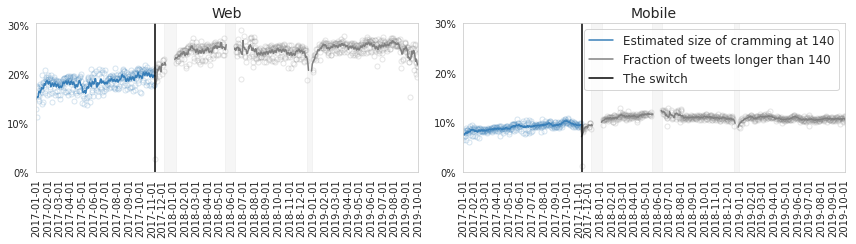

In [3]:
df_b = pd.read_csv("../data/measurements/daily_runover_vs_fraction_per_source.csv.gz", index_col='created_at')
df_b.index = pd.to_datetime(df_b.index)

def plot_daily_measurements(ax, df, source_type):
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')    

    df1 = df[(df.source_type == source_type) & (df.measure == 'runover')][['measurement']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index_before = df1[df1.index.day == 1]['index'].values
    month_label_before = df1[df1.index.day == 1].index.astype(str)
    
    df2 = df[(df.source_type == source_type) & (df.measure == 'cramming')][['measurement']].sort_index()
    df2.index = df2.index.date
    new_index = pd.date_range(df2.index.min(), df2.index.max(), freq='D')
    df2 = df2.reindex(new_index)
    df2 = df2.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    ax.plot(range(0, len(df2)), df2.measurement.values, linestyle='none', marker='o', markersize=5, 
             fillstyle='none', alpha=0.2, color='#377eb8')
    
    df3 = df[(df.source_type == source_type) & (df.measure == 'empirical fraction')][['measurement']].sort_index()
    df3.index = df3.index.date
    new_index = pd.date_range(df3.index.min(), df3.index.max(), freq='D')
    df3 = df3.reindex(new_index)
    df3 = df3.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    ax.plot(range(len(df1), len(df1)+len(df3)), df3.measurement.values,\
            linestyle='none', marker='o', markersize=5, 
            fillstyle='none', alpha=0.2, color='gray')
    
    first_in_month_index_after = df3[df3.index.day == 1]['index'].values + first_in_month_index_before[-1]
    month_label_after = df3[df3.index.day == 1].index.astype(str)

    smoothed_runover = pd.DataFrame(df1.measurement.values).rolling(10, min_periods=2, center=True).mean()
    smoothed_cramming = pd.DataFrame(df2.measurement.values).rolling(10, min_periods=2, center=True).mean()
    smoothed_fraction = pd.DataFrame(df3.measurement.values).rolling(10, min_periods=2, center=True).mean()

   # smoothed_fraction[30:54] = np.nan
    #smoothed_fraction[183:210] = np.nan
    #smoothed_fraction[398:411] = np.nan
        

    ax.plot(smoothed_cramming, color = '#377eb8', label='Estimated size of cramming at 140')
    ax.plot(range(len(df1), len(df1)+len(df3)), smoothed_fraction, color = 'gray', label='Fraction of tweets longer than 140')
    
    ax.set_xticks(np.concatenate((first_in_month_index_before, first_in_month_index_after)))
    ax.set_xticklabels([])
    
    ax.set_yticks([0, 0.1, 0.2,0.3])

    ax.set_yticklabels(["0%","10%","20%","30%"])
    
    ax.set_title(source_type.capitalize(), fontsize= 14)
    ax.axvline(310, ymin=-0.01, ymax=1, color='black', label='The switch')
    #ax.set_ylabel('Measurements')
    ax.set_xlim(first_in_month_index_before[0],first_in_month_index_after[-1])
    ax.grid(False) 
    
    if source_type!='web':
        ax.legend(  fontsize= 12)
    return ax, np.concatenate((month_label_before, month_label_after))

sources = ['web', 'mobile']
fig, axes = plt.subplots(1,len(sources), figsize= (12, 3.5), sharey=False)
for ax, source_type in zip(axes, sources):
    ax, month_label = plot_daily_measurements(ax, df_b, source_type)
    #ax.set_xlabel('date')
    ax.set_xticklabels(month_label, rotation=90);
    
#plt.grid(axis='y', alpha = 0.01,) 

fig.tight_layout()
plt.savefig("rq1.pdf", bbox_inches='tight');



## Figure 3

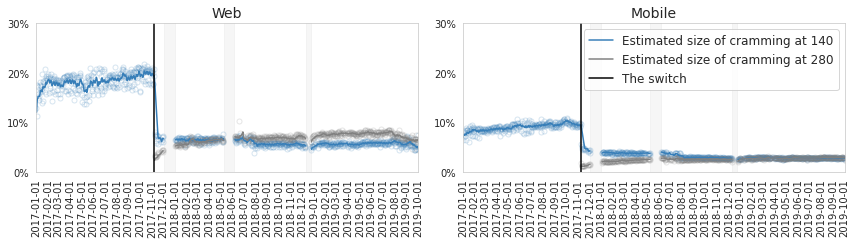

In [4]:
df = pd.read_csv("../data/measurements/fig9_daily_cramming_per_source.csv.gz", index_col='created_at')
df.index = pd.to_datetime(df.index)
df.head()

def plot_daily_cramming(ax, df, source_type):
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')    

    df1 = df[(df.source_type == source_type) & (df.cramming_at == 140)][['cramming']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index = df1[df1.index.day == 1]['index'].values
    month_label = df1[df1.index.day == 1].index.astype(str)
    plotting_indices = df1['index'].values

    ax.plot(range(0, len(df1)), df1.cramming.values, linestyle='none', marker='o', markersize=5, 
             fillstyle='none', alpha=0.2, color='#377eb8')

    df2 = df[(df.source_type == source_type) & (df.cramming_at == 280)][['cramming']].sort_index()
    df2.index = df2.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df2 = df2.reindex(new_index)
    df2 = df2.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    ax.plot(range(311, len(df1)), df2[df2["index"] > 310].cramming.values, linestyle= 'none',marker = 'o', markersize = 5, 
             fillstyle = 'none', alpha = 0.2, color = 'gray')

    smoothed140 = pd.DataFrame(df1.cramming.values).rolling(10, min_periods=2).mean()
    smoothed280 = pd.DataFrame(df2.cramming.values).rolling(10, min_periods=2).mean()

    smoothed140[335:364], smoothed280[335:364] = np.nan, np.nan
    smoothed140[493:520], smoothed280[493:520] = np.nan, np.nan
    smoothed140[708:721], smoothed280[708:721] = np.nan, np.nan

    ax.plot(smoothed140, color = '#377eb8', label='Estimated size of cramming at 140')
    ax.plot(smoothed280, color = 'gray', label='Estimated size of cramming at 280')
    
    ax.set_xticks(first_in_month_index)
    ax.set_xticklabels([])
    
    ax.set_yticks([0, 0.1, 0.2,0.3])
    ax.set_yticklabels(["0%","10%","20%","30%"])
    
    ax.set_title(source_type.capitalize(),  fontsize= 14)
    ax.axvline(df1[df1.index == "2017-11-07"]['index'].values[0], \
                ymin=-0.01, ymax=1, color='black', label='The switch')
    #ax.set_ylabel('Cramming')
    ax.grid(False) 
    
    if source_type!='web':
        ax.legend(  fontsize= 12)
        
    ax.set_xlim(first_in_month_index[0],first_in_month_index[-1])
    return ax, month_label

fig, axes = plt.subplots(1,len(sources), figsize= (12, 3.5), sharey=False)
sources = ['web', 'mobile']
for ax, source_type in zip(axes, sources):
    ax, month_label = plot_daily_cramming(ax, df, source_type)
    #ax.set_xlabel('date')
    ax.set_xticklabels(month_label, rotation=90);
    

fig.tight_layout()
plt.savefig("rq2.pdf", bbox_inches='tight');

## Figure 5

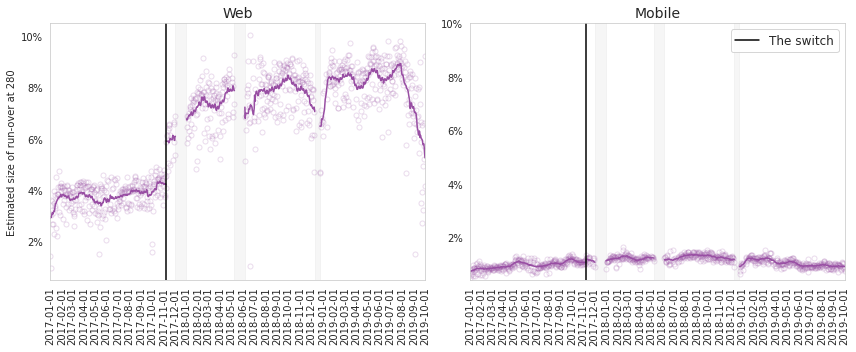

In [5]:
df_a = pd.read_csv("../data/measurements/daily_runover_vs_cramming_per_source.csv.gz", index_col='created_at')
df_a.index = pd.to_datetime(df_a.index)

def plot_daily_cramming_runover(ax, df, source_type):
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')    

    df1 = df[(df.source_type == source_type) & (df.measure == 'runover')][['measurement']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index = df1[df1.index.day == 1]['index'].values
    month_label = df1[df1.index.day == 1].index.astype(str)

    ax.plot(range(0, 311), df1.measurement.values[:311], linestyle='none', marker='o', markersize=5, 
             fillstyle='none', alpha=0.2, color='#984ea3')
    
    ax.plot(range(311, len(df1)), df1.measurement.values[311:], linestyle='none', marker='o', markersize=5, 
            fillstyle='none', alpha=0.2, color='#984ea3')

    df2 = df[(df.source_type == source_type) & (df.measure == 'cramming')][['measurement']].sort_index()
    df2.index = df2.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df2 = df2.reindex(new_index)
    df2 = df2.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")


    smoothed_runover_before = pd.DataFrame(df1.measurement.values[:311])\
        .rolling(25, min_periods=2, center=True).mean()
    smoothed_runover_after = pd.DataFrame(df1.measurement.values[311:])\
        .rolling(25, min_periods=2, center=True).mean()
    smoothed_cramming = pd.DataFrame(df2.measurement.values)\
        .rolling(25, min_periods=2, center=True).mean()
        
    smoothed_cramming[335:364] = np.nan
    smoothed_cramming[493:520] = np.nan
    smoothed_cramming[708:721] = np.nan
    # that line appears after the switch so instead of our 
    # usual indices we need to subtract 310 from them
    smoothed_runover_after[25:54] = np.nan
    smoothed_runover_after[183:210] = np.nan
    smoothed_runover_after[398:411] = np.nan

    ax.plot(smoothed_runover_before, color = '#984ea3')
    ax.plot(range(311, len(df1)), smoothed_runover_after, color='#984ea3')

    
    ax.set_xticks(first_in_month_index)
    ax.set_xticklabels([])
    
    ax.set_yticks([0.02, 0.04, 0.06, 0.08, 0.1])
    ax.set_yticklabels(["2%","4%","6%", "8%", "10%"])
    
    ax.set_title(source_type.capitalize(), fontsize= 14)
    ax.axvline(df1[df1.index == "2017-11-07"]['index'].values[0], \
                ymin=-0.01, ymax=1, color='black', label='The switch')
    #ax.set_ylabel('Measurements')
    ax.grid(False)  
    if source_type!='web':
        ax.legend(loc = "upper right",  fontsize= 12)
    else:
        ax.set_ylabel('Estimated size of run-over at 280')
    ax.set_xlabel('')
    
    ax.set_xlim(first_in_month_index[0],first_in_month_index[-1])
    ax.set_xticklabels(month_label, rotation=90); 
    
    return ax, month_label, smoothed_cramming

sources = ['web', 'mobile']
fig, axes = plt.subplots(1,len(sources), figsize= (12, 5), sharey=False)
for ax, source_type in zip(axes, sources):
    ax, month_label, sc = plot_daily_cramming_runover(ax, df_a, source_type)
    
    
    
fig.tight_layout()
plt.savefig("rq4_a.pdf", bbox_inches='tight');

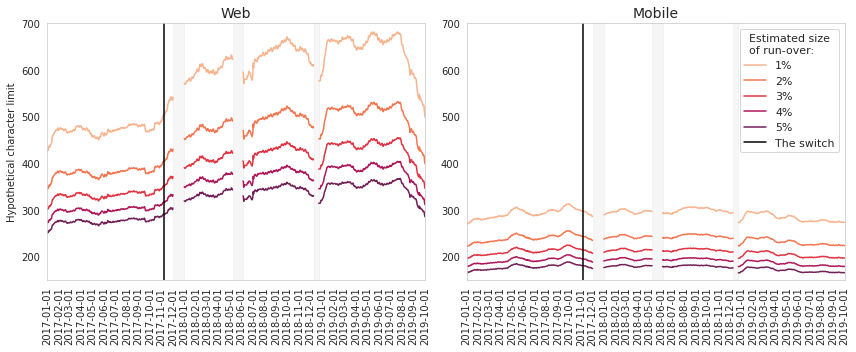

In [7]:
df = pd.read_csv("../data/measurements/daily_num_chars_per_source.csv.gz", index_col='created_at')
df.index = pd.to_datetime(df.index)
def plot_daily_num_chars(ax, df, source_type, probs):
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')  
    
    for cnt,prob in enumerate(probs[::-1]):
        df1 = df[(df.source_type == source_type) & (df.probability == prob)].sort_index()
        df1.index = df1.index.date
        new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
        df1 = df1.reindex(new_index)
        df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

        first_in_month_index = df1[df1.index.day == 1]['index'].values
        month_label = df1[df1.index.day == 1].index.astype(str)

        smoothed_num_chars = pd.DataFrame(df1.num_chars.values)\
                                              .rolling(25, min_periods=2, center=True).mean()

        # that line appears after the switch
        # so instead of our usual indices we need to subtract 310 from them
        smoothed_num_chars[335:364] = np.nan
        smoothed_num_chars[493:520] = np.nan
        smoothed_num_chars[708:721] = np.nan

        ax.plot(smoothed_num_chars, label=f'{int((1-prob)*100)}%', color = sns.color_palette("rocket_r")[cnt])

    ax.set_xticks(first_in_month_index)
    ax.set_xticklabels([])
    
    ax.set_title(source_type.capitalize(),fontsize= 14)
    ax.axvline(df1[df1.index == "2017-11-07"]['index'].values[0], \
                ymin=-0.01, ymax=1, color='black',label = "The switch")
    
    ax.grid(False) 

    
    if source_type!='web':
        ax.legend(ncol=1, loc='upper right',frameon=True, fontsize=11)
        leg = ax.get_legend()
        leg.set_title("Estimated size\nof run-over:",prop={'size':11})
    else:
        ax.set_ylabel('Hypothetical character limit')
        
    ax.set_xlim(first_in_month_index[0],first_in_month_index[-1])
    ax.set_ylim(150,700)
    return ax, month_label

sources = ['web', 'mobile']

fig, axes = plt.subplots(1,len(sources), figsize= (12, 5), sharey=False)
for ax, source_type in zip(axes, sources):
    ax, month_label = plot_daily_num_chars(ax, df, source_type, probs=df.probability.unique())
    #ax.set_xlabel('date')
    ax.set_xticklabels(month_label, rotation=90)
    

        
fig.tight_layout()
plt.savefig("rq4_b.pdf", bbox_inches='tight');




## Panels

In [8]:
df = pd.read_csv('../data/measurements/daily_measures_per_lang_per_source.csv.gz')

In [9]:
df

,created_at,source_type,lang,measurement,measure,measurement_at
0,2017-01-01,automated,ar,0.152746,cramming,140
1,2017-01-02,automated,ar,0.159620,cramming,140
2,2017-01-03,automated,ar,0.148830,cramming,140
3,2017-01-04,automated,ar,0.162222,cramming,140
4,2017-01-05,automated,ar,0.161669,cramming,140
...,...,...,...,...,...,...
202265,2019-09-27,web,zh,0.000000,empirical fraction,140
202266,2019-09-28,web,zh,0.027027,empirical fraction,140
202267,2019-09-29,web,zh,0.015152,empirical fraction,140
202268,2019-09-30,web,zh,0.047619,empirical fraction,140


In [10]:
df['after_switch'] = df.created_at>"2017-11-07"

In [11]:
df['lang'].unique()

array(['ar', 'de', 'en', 'es', 'et', 'fa', 'fr', 'hi', 'ht', 'in', 'it',
       'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'th', 'tl', 'tr', 'ur',
       'zh'], dtype=object)

In [12]:
df['measure'].unique()

array(['cramming', 'runover', 'empirical fraction'], dtype=object)

In [13]:
lang_with_switch = ['ar', 'nl', 'en', 'et', 'fr', 'de', 'ht', 'hi', 'in', 'it', 
                     'fa', 'pl', 'pt', 'ru', 'es', 'sv', 'tl', 'th', 'tr', 'ur']

In [14]:
len(lang_with_switch)

20

### 1. Cramming 140 vs cramming 280

Text(0, 0.5, 'Percentage')

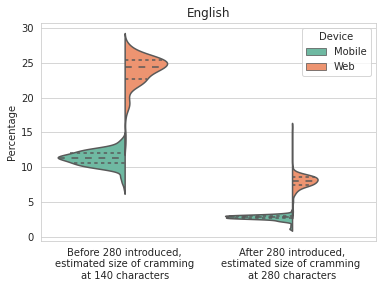

In [15]:
t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['measure']=='cramming') & 
      (df['lang']=='en')]

t = t.loc[((t['after_switch']==False)&(t['measurement_at']==140)) | \
          ((t['after_switch']==True)&(t['measurement_at']==280))]
t['measurement'] = t['measurement']*100
t['Device'] = t['source_type']
t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
t['Device'] = t['Device'].str.replace('web', 'Web')
ax = sns.violinplot(x="after_switch", y="measurement", hue="Device",
                    data=t, palette="Set2", split=True,
                    scale="area", inner="quartile", saturation = 0.8)
plt.title('English')

plt.xlabel('')
plt.xticks([False,True],['Before 280 introduced,\nestimated size of cramming\nat 140 characters','After 280 introduced,\nestimated size of cramming \nat 280 characters']);
plt.ylabel('Percentage')

In [16]:
import math

mapping_lang_codes = {}
mapping_lang_codes['ja'] = 'Japanese'
mapping_lang_codes['en'] = 'English'
mapping_lang_codes['pt'] = 'Portuguese'
mapping_lang_codes['es'] = 'Spanish'
mapping_lang_codes['ar'] = 'Arabic'
mapping_lang_codes['ko'] = 'Korean'
mapping_lang_codes['in'] = 'Indonesian'
mapping_lang_codes['tl'] = 'Tagalog'
mapping_lang_codes['tr'] = 'Turkish'
mapping_lang_codes['fr'] = 'French'
mapping_lang_codes['th'] = 'Thai'
mapping_lang_codes['ru'] = 'Russian'
mapping_lang_codes['it'] = 'Italian'
mapping_lang_codes['de'] = 'German'
mapping_lang_codes['pl'] = 'Polish'
mapping_lang_codes['hi'] = 'Hindi'
mapping_lang_codes['fa'] = 'Persian'
mapping_lang_codes['nl'] = 'Dutch'
mapping_lang_codes['ht'] = 'Haitian Creole'
mapping_lang_codes['et'] = 'Estonian'
mapping_lang_codes['zh'] = 'Chinese'
mapping_lang_codes['ur'] = 'Urdu'
mapping_lang_codes['sv'] = 'Swedish'

In [17]:
mapping_lang_codes = dict(sorted(mapping_lang_codes.items(), key=lambda item: item[1]))

In [18]:
mapping_lang_codes.values()

dict_values(['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'German', 'Haitian Creole', 'Hindi', 'Indonesian', 'Italian', 'Japanese', 'Korean', 'Persian', 'Polish', 'Portuguese', 'Russian', 'Spanish', 'Swedish', 'Tagalog', 'Thai', 'Turkish', 'Urdu'])

In [19]:
mapping_lang_codes.keys()

dict_keys(['ar', 'zh', 'nl', 'en', 'et', 'fr', 'de', 'ht', 'hi', 'in', 'it', 'ja', 'ko', 'fa', 'pl', 'pt', 'ru', 'es', 'sv', 'tl', 'th', 'tr', 'ur'])

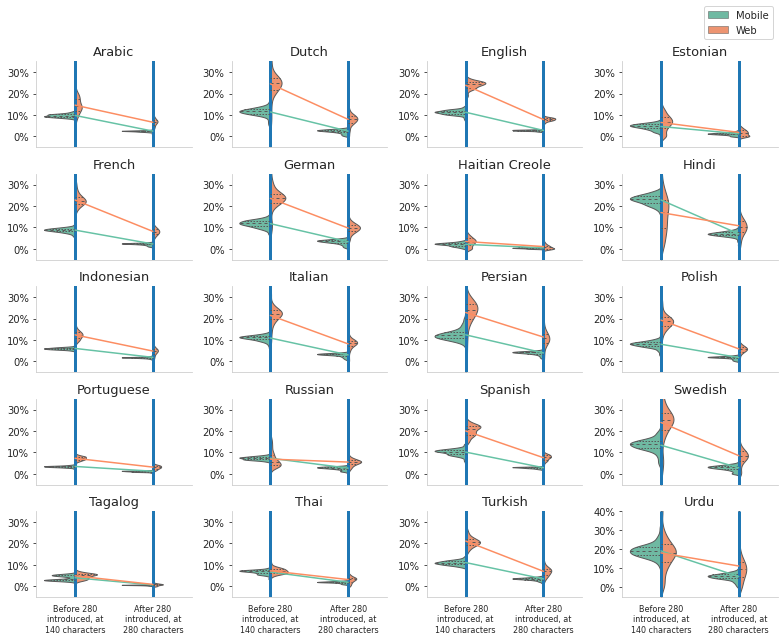

In [20]:
fig, ax = plt.subplots(5,4,figsize = (11,9), sharey = True, sharex = True)

for i in range(20):
    lang = lang_with_switch[i]
    sbplt = ax[ math.floor(i/4), i%4]

    sbplt.set_title(mapping_lang_codes[lang], fontsize = 13)
    
    t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['measure']=='cramming') & 
      (df['lang']==lang)]

    t = t.loc[((t['after_switch']==False)&(t['measurement_at']==140)) | \
              ((t['after_switch']==True)&(t['measurement_at']==280))]
    t['measurement'] = t['measurement']*100
    t['Device'] = t['source_type']
    t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
    t['Device'] = t['Device'].str.replace('web', 'Web')
    t['after_switch'] = t['after_switch'].astype(int)
    
    ax1 = sns.violinplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",
                        data=t, palette="Set2", split=True,linewidth = 1,
                        scale="area", inner="quartile", saturation = 0.8)
    
    ax1 = sns.lineplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",markersize=0,
                        data=t, palette="Set2", legend = False, ci = None)
    
    # Hide the right and top spines
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    
    # Only show ticks on the left and bottom spines
    sbplt.yaxis.set_ticks_position('left')
    sbplt.grid(b=None)

    if i ==3:
        sbplt.legend(bbox_to_anchor=(1, 1.7))
    else:
        sbplt.legend([],[], frameon=False)
    sbplt.set_ylim([-5,35])
    sbplt.vlines(True, -5,40, linewidth =3)
    sbplt.vlines(False, -5,40, linewidth =3)
    sbplt.set_xlabel('')
    if i>15:
        sbplt.set_xticklabels(['Before 280\nintroduced, at\n140 characters','After 280\nintroduced, at\n280 characters'],
                             fontsize = 8);
    else:
        sbplt.set_xticklabels([])
    sbplt.set_ylabel('')
    sbplt.set_yticks([0,10,20,30,40])
    sbplt.set_yticklabels(['0%','10%','20%','30%','40%'])
    sbplt.set_xlim([-0.5,1.5])

fig.tight_layout()
#fig.suptitle('Estimated size of cramming', 
#             y = 1, fontsize = 15)


plt.savefig("cramming_langs_sources.pdf", bbox_inches='tight')


### 2. Cramming 140 vs fraction > 140

Text(0, 0.5, 'Percentage')

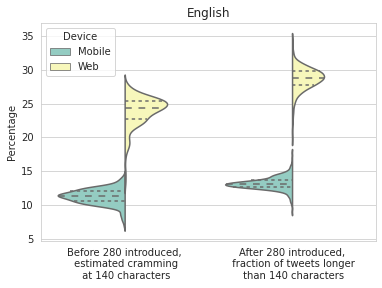

In [21]:
t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['lang']=='en')]

t = t.loc[((t['after_switch']==False)&(t['measurement_at']==140)&(t['measure']=='cramming')) | \
          ((t['after_switch']==True)&(t['measurement_at']==140)&(t['measure']=='empirical fraction'))]
t['measurement'] = t['measurement']*100
t['Device'] = t['source_type']
t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
t['Device'] = t['Device'].str.replace('web', 'Web')
ax = sns.violinplot(x="after_switch", y="measurement", hue="Device",
                    data=t, palette="Set3", split=True,
                    scale="area", inner="quartile", saturation = 0.8)
plt.title('English')

plt.xlabel('')
plt.xticks([False,True],['Before 280 introduced,\n estimated cramming\n at 140 characters','After 280 introduced,\n fraction of tweets longer\n than 140 characters']);
plt.ylabel('Percentage')

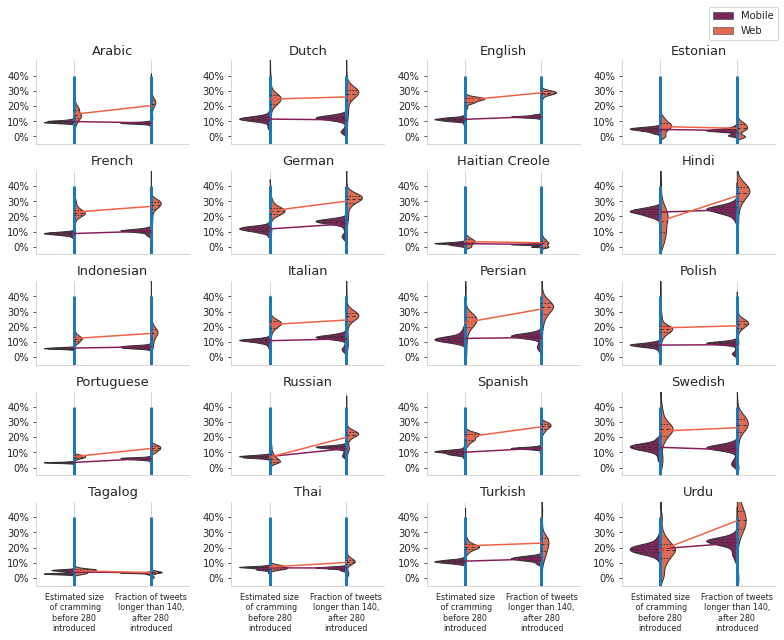

In [22]:
fig, ax = plt.subplots(5,4,figsize = (11,9), sharey = True, sharex = True)

for i in range(20):
    lang = lang_with_switch[i]
    sbplt = ax[ math.floor(i/4), i%4]

    sbplt.set_title(mapping_lang_codes[lang], fontsize = 13)
    
    t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['lang']==lang)]

    t = t.loc[((t['after_switch']==False)&(t['measurement_at']==140)&(t['measure']=='cramming')) | \
          ((t['after_switch']==True)&(t['measurement_at']==140)&(t['measure']=='empirical fraction'))]


    t['measurement'] = t['measurement']*100
    t['Device'] = t['source_type']
    t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
    t['Device'] = t['Device'].str.replace('web', 'Web')
    t['after_switch'] = t['after_switch'].astype(int)
    
    ax1 = sns.violinplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",
                        data=t, palette="rocket", split=True,linewidth = 1,
                        scale="area", inner="quartile", saturation = 0.8)
    
    ax1 = sns.lineplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",markersize=0,
                        data=t, palette="rocket", legend = False, ci = None)
    
    # Hide the right and top spines
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    
    # Only show ticks on the left and bottom spines
    sbplt.yaxis.set_ticks_position('left')
    sbplt.grid(b=None)

    if i ==3:
        sbplt.legend(bbox_to_anchor=(1.05, 1.7))
    else:
        sbplt.legend([],[], frameon=False)
    sbplt.set_ylim([-5,50])
    sbplt.vlines(True, -5,40, linewidth =3)
    sbplt.vlines(False, -5,40, linewidth =3)
    sbplt.set_xlabel('')
    if i>15:
        sbplt.set_xticklabels(['Estimated size\n of cramming\nbefore 280\nintroduced','Fraction of tweets\nlonger than 140,\nafter 280\nintroduced'],
                             fontsize = 8);
    else:
        sbplt.set_xticklabels([])
    sbplt.set_ylabel('')
    sbplt.set_yticks([0,10,20,30,40])
    sbplt.set_yticklabels(['0%','10%','20%','30%','40%'])
    sbplt.set_xlim([-0.5,1.5])

fig.tight_layout()
#fig.suptitle('Estimated size of cramming', y = 1, fontsize = 15)


plt.savefig("cramming_fraction_langs_sources.pdf", bbox_inches='tight')

### 3. Runover 280 vs runover 280

Text(0, 0.5, 'Percentage')

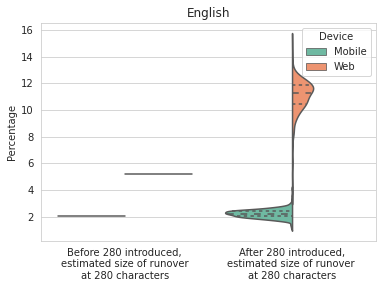

In [23]:
t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['measure']=='runover') & 
      (df['lang']=='en')]

t = t.loc[((t['after_switch']==False)&(t['measurement_at']==280)) | \
          ((t['after_switch']==True)&(t['measurement_at']==280))]
t['measurement'] = t['measurement']*100
t['Device'] = t['source_type']
t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
t['Device'] = t['Device'].str.replace('web', 'Web')
ax = sns.violinplot(x="after_switch", y="measurement", hue="Device",
                    data=t, palette="Set2", split=True,
                    scale="area", inner="quartile", saturation = 0.8)
plt.title('English')

plt.xlabel('')
plt.xticks([False,True],['Before 280 introduced,\nestimated size of runover\nat 280 characters','After 280 introduced,\nestimated size of runover \nat 280 characters']);
plt.ylabel('Percentage')

In [24]:
def lower_error(data):
	nbr_draws = 1000
	means = np.zeros(nbr_draws)
	data = np.array(data)

	for n in range(nbr_draws):
		indices = np.random.randint(0, len(data), len(data))
		data_tmp = data[indices] 
		means[n] = np.nanmean(data_tmp)

	return np.nanpercentile(means, 2.5)

def upper_error(data):
	nbr_draws = 1000
	means = np.zeros(nbr_draws)
	data = np.array(data)

	for n in range(nbr_draws):
	    indices = np.random.randint(0, len(data), len(data))
	    data_tmp = data[indices] 
	    means[n] = np.nanmean(data_tmp)

	return np.nanpercentile(means, 97.5)

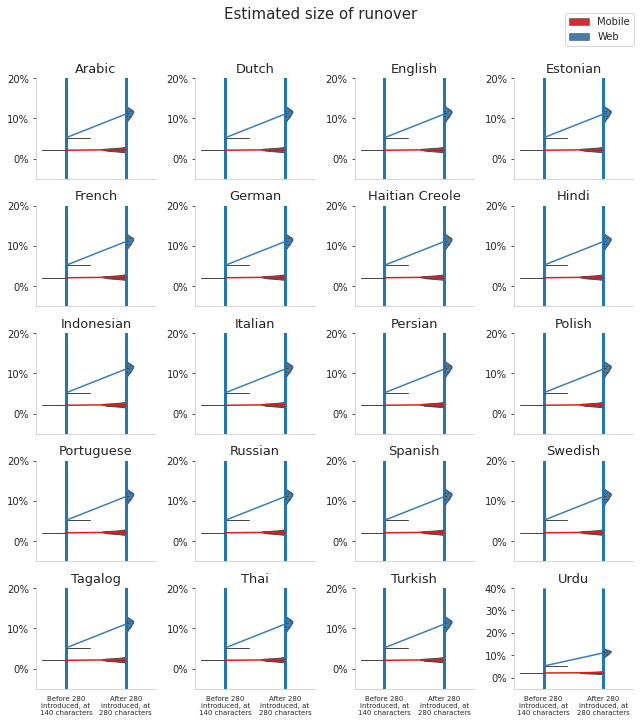

In [25]:

fig, ax = plt.subplots(5,4,figsize = (9,10), sharey = True, sharex = True)

for i in range(20):
    lang = lang_with_switch[i]
    sbplt = ax[ math.floor(i/4), i%4]

    sbplt.set_title(mapping_lang_codes[lang], fontsize = 13)
    
    t = df.loc[(df['source_type'].isin(['web','mobile'])) & 
      (~df['lang'].isin(['zh','ja','ko']))&
      (df['measure']=='runover') & 
      (df['lang']=='en')]

    t = t.loc[((t['after_switch']==False)&(t['measurement_at']==280)) | \
          ((t['after_switch']==True)&(t['measurement_at']==280))]


    t['measurement'] = t['measurement']*100
    t['Device'] = t['source_type']
    t['Device'] = t['Device'].str.replace('mobile', 'Mobile')
    t['Device'] = t['Device'].str.replace('web', 'Web')
    t['after_switch'] = t['after_switch'].astype(int)
    
    ax1 = sns.violinplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",
                        data=t, palette="Set1", split=True,linewidth = 1,
                        scale="area", inner="quartile", saturation = 0.8)
    
    ax1 = sns.lineplot(ax = sbplt, x="after_switch", y="measurement", hue="Device",markersize=0,
                        data=t, palette="Set1", legend = False, ci = None)
    
    # Hide the right and top spines
    sbplt.spines['right'].set_visible(False)
    sbplt.spines['top'].set_visible(False)
    
    # Only show ticks on the left and bottom spines
    sbplt.yaxis.set_ticks_position('left')
    sbplt.grid(b=None)

    if i ==3:
        sbplt.legend(bbox_to_anchor=(1.05, 1.7))
    else:
        sbplt.legend([],[], frameon=False)
    sbplt.set_ylim([-5,20])
    sbplt.vlines(True, -5,40, linewidth =3)
    sbplt.vlines(False, -5,40, linewidth =3)
    sbplt.set_xlabel('')
    if i>15:
        sbplt.set_xticklabels(['Before 280\nintroduced, at\n140 characters','After 280\nintroduced, at\n280 characters'],
                             fontsize = 7);
    else:
        sbplt.set_xticklabels([])
    sbplt.set_ylabel('')
    sbplt.set_yticks([0,10,20,30,40])
    sbplt.set_yticklabels(['0%','10%','20%','30%','40%'])
    sbplt.set_xlim([-0.5,1.5])

fig.tight_layout()
fig.suptitle('Estimated size of runover', 
             y = 1, fontsize = 15)


plt.savefig("runover_langs_sources.pdf", bbox_inches='tight')

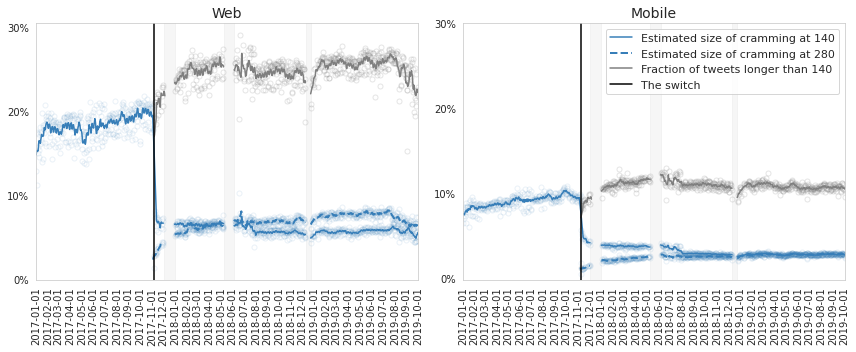

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.read_csv("../data/measurements/fig9_daily_cramming_per_source.csv.gz", index_col='created_at')
df1.index = pd.to_datetime(df1.index)
df1.head()

df2 = pd.read_csv("../data/measurements/daily_runover_vs_fraction_per_source.csv.gz", index_col='created_at')
df2.index = pd.to_datetime(df2.index)
df2.head()

def plot_daily_cramming(ax, df_cram, df_frac, source_type):
    cramming140_color = "#377eb8"
    cramming280_color = "#377eb8"
    fraction_color = "tab:gray"
    
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')    

    df1 = df_cram[(df_cram.source_type == source_type) & (df_cram.cramming_at == 140)][['cramming']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index = df1[df1.index.day == 1]['index'].values
    month_label = df1[df1.index.day == 1].index.astype(str)

    ax.plot(range(0, len(df1)), df1.cramming.values, linestyle='none', marker='o', markersize=5, 
             fillstyle='none', alpha=0.1, color=cramming140_color)

    df2 = df_cram[(df_cram.source_type == source_type) & (df_cram.cramming_at == 280)][['cramming']].sort_index()
    df2.index = df2.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df2 = df2.reindex(new_index)
    df2 = df2.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    ax.plot(range(310, len(df1)), df2[df2["index"] >= 310].cramming.values,
            linestyle='none',marker='o', markersize=5, 
            fillstyle='none', alpha=0.1, color=cramming280_color)
    
    df3 = df_frac[(df_frac.source_type == source_type) & (df_frac.measure == 'empirical fraction')][['measurement']].sort_index()
    df3.index = df3.index.date
    new_index = pd.date_range(df3.index.min(), df3.index.max(), freq='D')
    df3 = df3.reindex(new_index)
    df3 = df3.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    ax.plot(range(310, len(df1)), df3.measurement.values,\
            linestyle='none', marker='o', markersize=5, 
            fillstyle='none', alpha=0.2, color=fraction_color)
        
    smoothed140 = pd.DataFrame(df1.cramming.values).rolling(10, min_periods=2, center=True).mean()
    smoothed280 = pd.DataFrame(df2.cramming.values).rolling(10, min_periods=2, center=True).mean()
    smoothed_fraction = pd.DataFrame(df3.measurement.values).rolling(10, min_periods=2, center=True).mean()

    smoothed140[335:364], smoothed280[335:364] = np.nan, np.nan
    smoothed140[493:520], smoothed280[493:520] = np.nan, np.nan
    smoothed140[708:721], smoothed280[708:721] = np.nan, np.nan
    smoothed_fraction[30:54] = np.nan
    smoothed_fraction[183:210] = np.nan
    smoothed_fraction[398:411] = np.nan

    ax.plot(smoothed140, color=cramming140_color, label='Estimated size of cramming at 140')
    ax.plot(smoothed280, color=cramming280_color, label='Estimated size of cramming at 280', linestyle = 'dashed', linewidth = 2)
    ax.plot(range(310, len(df1)), smoothed_fraction, color=fraction_color, label='Fraction of tweets longer than 140')

    ax.set_xticks(first_in_month_index)
    ax.set_xticklabels([])
    
    ax.set_yticks([0.0, 0.1, 0.2, 0.3])
    ax.set_yticklabels(["0%","10%","20%", "30%"])
    
    ax.grid(False) 
    
    ax.set_title(source_type.capitalize(), fontsize= 14)
    ax.axvline(df1[df1.index == "2017-11-07"]['index'].values[0], \
                ymin=-0.01, ymax=1, color='black', label='The switch')
#     ax.set_ylabel('Cramming')
#     ax.grid(axis='y')
    return ax, month_label

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
sources = ['web', 'mobile']
for ax, source_type in zip(axes, sources):
    ax, month_label = plot_daily_cramming(ax, df1, df2, source_type)
    #ax.set_xlabel('date')
    ax.set_xticklabels(month_label, rotation=90)
    ax.set_xlim(0, 1003)
ax.legend(fontsize=11, loc = 'upper right')
#plt.subplots_adjust(wspace=0.1);

fig.tight_layout()

plt.savefig("daily_cramming_per_source.pdf", bbox_inches='tight');

In [27]:
def plot_daily_cramming(ax, df_cram, df_frac, source_type):
    df1 = df_cram[(df_cram.source_type == source_type) & (df_cram.cramming_at == 140)][['cramming']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index = df1[df1.index.day == 1]['index'].values
    month_label = df1[df1.index.day == 1].index.astype(str)

    print('cramming 140')
    print(round(np.nanmean(df1.cramming.values[df1["index"] < 310])*100,2))
    print(round(lower_error(df1.cramming.values[df1["index"] < 310])*100,2))
    print(round(upper_error(df1.cramming.values[df1["index"] < 310])*100,2))

    df2 = df_cram[(df_cram.source_type == source_type) & (df_cram.cramming_at == 280)][['cramming']].sort_index()
    df2.index = df2.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df2 = df2.reindex(new_index)
    df2 = df2.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    
    print('cramming 280')
    print(round(np.nanmean(df2[df2["index"] >= 310].cramming.values)*100,2))
    print(round(lower_error(df2[df2["index"] >= 310].cramming.values)*100,2))
    print(round(upper_error(df2[df2["index"] >= 310].cramming.values)*100,2))
    
    #ax.plot(range(310, len(df1)), df2[df2["index"] >= 310].cramming.values,
            #linestyle='none',marker='o', markersize=5, 
            #fillstyle='none', alpha=0.1, color=cramming280_color)

    df3 = df_frac[(df_frac.source_type == source_type) & (df_frac.measure == 'empirical fraction')][['measurement']].sort_index()
    df3.index = df3.index.date
    new_index = pd.date_range(df3.index.min(), df3.index.max(), freq='D')
    df3 = df3.reindex(new_index)
    df3 = df3.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")
    
    print('fraction>140')
    print(round(np.nanmean(df3.measurement.values*100),2))
    print(round(lower_error(df3.measurement.values*100),2))
    print(round(upper_error(df3.measurement.values*100),2))
    
    #ax.plot(range(310, len(df1)), df3.measurement.values,\
           # linestyle='none', marker='o', markersize=5, 
           # fillstyle='none', alpha=0.2, color=fraction_color)
    return ax, month_label

for ax, source_type in zip(axes, sources):
    print(source_type)
    ax, month_label = plot_daily_cramming(ax, df1, df2, source_type)
    print('\n')

web
cramming 140
18.35
18.15
18.56
cramming 280
6.88
6.8
6.96
fraction>140
24.81
24.66
24.95


mobile
cramming 140
9.06
8.97
9.15
cramming 280
2.55
2.53
2.58
fraction>140
10.88
10.81
10.93




In [28]:
df_a = pd.read_csv("../data/measurements/daily_runover_vs_cramming_per_source.csv.gz", index_col='created_at')
df_a.index = pd.to_datetime(df_a.index)

def plot_daily_cramming_runover(ax, df, source_type):
 

    df1 = df[(df.source_type == source_type) & (df.measure == 'runover')][['measurement']].sort_index()
    df1.index = df1.index.date
    new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
    df1 = df1.reindex(new_index)
    df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

    first_in_month_index = df1[df1.index.day == 1]['index'].values
    month_label = df1[df1.index.day == 1].index.astype(str)

    print(round(100*np.nanmean(df1.measurement.values[:311]),2))
    print(round(100*lower_error(df1.measurement.values[:311]),2))
    print(round(100*upper_error(df1.measurement.values[:311]),2))
    
    print('\n')
    print(round(100*np.nanmean(df1.measurement.values[311:]),2))
    print(round(100*lower_error(df1.measurement.values[311:]),2))
    print(round(100*upper_error(df1.measurement.values[311:]),2))
    print('\n')
    
    return ax, month_label, new_index

sources = ['web', 'mobile']

for ax, source_type in zip(axes, sources):
    print(source_type)
    ax, month_label, sc = plot_daily_cramming_runover(ax, df_a, source_type)
    
    


web
3.76
3.7
3.83


7.77
7.67
7.85


mobile
0.97
0.96
0.99


1.15
1.14
1.16




In [29]:
df = pd.read_csv("../data/measurements/daily_num_chars_per_source.csv.gz", index_col='created_at')
df.index = pd.to_datetime(df.index)
def plot_daily_num_chars(ax, df, source_type, probs):
    ax.axvspan(335,364, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(493,520, ymin=0, ymax=3, alpha=0.2, color='lightgray')
    ax.axvspan(708,721, ymin=0, ymax=3, alpha=0.2, color='lightgray')  
    
    for cnt,prob in enumerate(probs[::-1]):
        print(prob)
        print(1-prob)
        df1 = df[(df.source_type == source_type) & (df.probability == prob)].sort_index()
        df1.index = df1.index.date
        new_index = pd.date_range(df1.index.min(), df1.index.max(), freq='D')
        df1 = df1.reindex(new_index)
        df1 = df1.reset_index().rename({"index": "date"}, axis=1).reset_index().set_index("date")

        first_in_month_index = df1[df1.index.day == 1]['index'].values
        month_label = df1[df1.index.day == 1].index.astype(str)

        smoothed_num_chars = pd.DataFrame(df1.num_chars.values)\
                                              .rolling(25, min_periods=2, center=True).mean()

        print(round(np.nanmean(df1.num_chars.values[:311])))
        print(round(lower_error(df1.num_chars.values[:311])))
        print(round(upper_error(df1.num_chars.values[:311])))
        
        print('\n')
        
        print(round(np.nanmean(df1.num_chars.values[311:])))
        print(round(lower_error(df1.num_chars.values[311:])))
        print(round(upper_error(df1.num_chars.values[311:])))
        
        print('\n')
    return ax, month_label

sources = ['web', 'mobile']

for ax, source_type in zip(axes, sources):
    print(source_type)
    ax, month_label = plot_daily_num_chars(ax, df, source_type, probs=df.probability.unique())
    print('\n')
    


web
0.99
0.010000000000000009
471
467
474


628
623
633


0.98
0.020000000000000018
380
377
382


493
489
496


0.97
0.030000000000000027
331
329
334


422
419
425


0.96
0.040000000000000036
299
297
301


376
373
378


0.95
0.050000000000000044
275
273
277


342
340
344




mobile
0.99
0.010000000000000009
293
291
294


291
290
292


0.98
0.020000000000000018
240
238
241


237
237
238


0.97
0.030000000000000027
211
210
212


209
208
209


0.96
0.040000000000000036
192
191
193


189
189
190


0.95
0.050000000000000044
178
177
179


175
174
176




